In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from pathlib import Path
import pickle

from tqdm import tqdm
from functools import partial

import scipy.stats as sp
import openturns as ot
import time

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.sample_bn import generate_samples
from py_banshee.prediction import inference,conditional_margins_hist
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance

import scipy.stats as st
import seaborn as sns
# from sklearn_extra.cluster import KMedoids

ModuleNotFoundError: No module named 'openturns'

In [ ]:

distributions = {
    'normal': st.norm, # loc, scale
    'lognormal': st.lognorm, # shape, loc, scale
    'gamma': st.gamma, # gamma, loc, scale
    'gumbel_r': st.gumbel_r, # loc, scale
    'gumbel_l': st.gumbel_l, # loc, scale
    'invweibull': st.invweibull, # c, loc, scale
    'weibull_min': st.weibull_min, # c, loc, scale
    'weibull_max': st.weibull_max, # c, loc, scale
    'exponential': st.expon, # loc, scale
    'rayleigh': st.rayleigh, # loc, scale
    'uniform': st.uniform, # loc, scale
    'truncatednormal': st.truncnorm, # a, b, loc, scale
    'pareto': st.pareto, # b, loc, scale
    'logistic': st.logistic, # loc, scale
}

In [ ]:
class DistributionLoader():
    """Loads distributions for a certain index of the DataFrame."""

    def __init__(self, df, colname, valmin, valmax):
        self.df = df
        self.index = self.df.index
        self.colname = colname
        self.valmin = valmin
        self.valmax = valmax
        self.pdfrange = np.arange(valmin, valmax, 0.01)

        self.distributions = {
            'normal': st.norm, # loc, scale
            'lognormal': st.lognorm, # shape, loc, scale
            'gamma': st.gamma, # gamma, loc, scale
            'gumbel_r': st.gumbel_r, # loc, scale
            'gumbel_l': st.gumbel_l, # loc, scale
            'invweibull': st.invweibull, # c, loc, scale
            'weibull_min': st.weibull_min, # c, loc, scale
            'weibull_max': st.weibull_max, # c, loc, scale
            'exponential': st.expon, # loc, scale
            'rayleigh': st.rayleigh, # loc, scale
            'uniform': st.uniform, # loc, scale
            'truncatednormal': st.truncnorm, # a, b, loc, scale
            'pareto': st.pareto, # b, loc, scale
            'logistic': st.logistic, # loc, scale
        }


    def _param_str_to_params(self, param_str):
        """Converts a parameter string to a list of parameters."""
        return [float(p) for p in param_str[1:-1].split()]
    
    def get_distribution(self, index, hour):
        """Returns the distribution for the given index and hour."""
        col0name = f'{self.colname}_{hour}'
        dist_name = self.df.loc[index, (col0name, 'dist')]
        params_str = self.df.loc[index, (col0name, 'params')]
        dist_params = self._param_str_to_params(params_str)
        return dist_name, dist_params
    
    def sample_distribution(self, index, hour):
        """Samples the distribution for the given index and hour."""
        dist_name, dist_params = self.get_distribution(index, hour)
        return self.distributions[dist_name].rvs(*dist_params, size=2000)
    
    def get_pdf(self, index, hour):
        """Returns the PDF for the given index and hour."""
        dist_name, dist_params = self.get_distribution(index, hour)
        return [self.distributions[dist_name].pdf(p, *dist_params) for p in self.pdfrange]
    
    def get_cdf(self, index, hour):
        """Returns the CDF for the given index and hour."""
        dist_name, dist_params = self.get_distribution(index, hour)
        return [self.distributions[dist_name].cdf(p, *dist_params) for p in self.pdfrange]
    
    def plot_pdf(self, index, hour, ax=None, title=None, return_distname=False):
        """Plots the PDF for the given index and hour."""
        dist_name, dist_params = self.get_distribution(index, hour)

        if not ax:
            fig, ax = plt.subplots(figsize=(4, 2))

        ax.plot(self.pdfrange, self.get_pdf(index, hour))

        # ax2 = ax.twinx()
        ax.hist(self.sample_distribution(index, hour), bins=50, density=True, alpha=0.5, color='C0')
        if not title:
            ax.set_title(f'{dist_name} PDF')
        else:
            ax.set_title(title)
        ax.set_xlim(self.valmin, self.valmax)
        if return_distname:
            return dist_name
        # ax2.set_xlim(self.valmin, self.valmax)

        # ax.set_ylim(0, 1)
        # ax2.set_ylim(0, 1)


    

In [ ]:
class BN():
    
    def __init__(self, historic_data, distributionloader, R=None, parent_cell=None, names=None, varname=None, n=48, threshold=0.5):
        self.data = historic_data
        self.distributionloader = distributionloader
        self.parent_cell = parent_cell
        self.names = names
        self.n = n
        self.varname = varname
        self.threshold = threshold
        self.R = R

    def make_structure(self, method='rankcorr'):
        if not self.parent_cell:
            self.make_structure_names()

        if not self.R:
            if method=='rankcorr':
                self.R = bn_rankcorr(parent_cell=self.parent_cell, data=self.data, var_names=self.names, is_data=True, plot=False)  
            else:
                raise NotImplementedError('Only rankcorr is implemented')
        
        if self.threshold:
            self.R = np.where(self.R > self.threshold, self.R, 0)

    def make_structure_names(self):
        # Name the nodes
        names  = [self.varname]*self.n
        names = [names[i]+str(i+1) for i in range(self.n)]
        
        days=int(self.n/24)
        
        if days==1:
            # Define structure by giving each node a parent cell, except node 0.
            parent_cell = [[] if i==0 else [0, i-1] for i in range(self.n)]
            parent_cell[1] = [0]
            
        if days>1:
            # Define structure by giving each node a parent cell, except node 0.

            # Initialize empty structure
            parent_cell = [[] if i==0 else [int(np.floor(i/24))*24, i-1] for i in range(self.n)]
            
            # Define the first node (connected to node 0).
            parent_cell[1] = [0]

            # Connect the nodes to the previous day.
            for i in range(24, self.n, 24):
                parent_cell[i] = [i-1]
            
            # Connect the nodes to the previous hour.
            for i in range(24, self.n):
                parent_cell[i] =  [i-24] + parent_cell[i]
            
            # Connect the nodes to the previous day and hour.
            parent_cell[25] = [1, 24]
        
        self.parent_cell = parent_cell
        self.names = names

    def make_copula(self, method='gaussian'):
        if not self.R:
            self.make_structure()
        
        if method=='gaussian':
            self.copula = ot.NormalCopula(self.R)
        else:
            raise NotImplementedError('Only gaussian is implemented')
        
    def get_marginals(self):
        if not self.copula:
            self.make_copula()
            
        self.marginals = {n: self.copula.getMarginal(i) for i, n in enumerate(self.names)}
    
    def get_distribution(self, index, hour):
        """Returns the distribution for the given index and hour."""
        return self.distributionloader.get_distribution(index, hour)
    
    def get_forecast_distributions(self, index):
        """Returns the distributions for the given index."""
        return [self.get_distribution(index, hour) for hour in range(1, self.n+1)]
    
    def sample_BN(self, index, N_samples=1000):
        """Samples the BN for the given index."""
        distributions, parameters = zip(*self.get_forecast_distributions(index))
        distributions = [self.distributionloader.distributions[d].name for d in distributions]
        return generate_samples(
                    R=self.R,
                    n=N_samples,
                    names=self.names,
                    data=[],
                    empirical_data=False,
                    distributions=list(distributions),
                    parameters=list(parameters)
                )
    
    def __call__(self, i, N_samples=1000):
        return self.sample_BN(self.distributionloader.index[i], N_samples)
    
    def plot_scenarios(self, index, N_samples=100, ax=None, title=None):
        """Plots the scenarios for the given index."""
        if not ax:
            fig, ax = plt.subplots(figsize=(4, 2))

        if type(index) == int:
            index = self.distributionloader.index[index]
            
        scenarios = self.sample_BN(index, N_samples)
        ax.plot(scenarios.T, lw=0.5, color='C0', alpha=0.5)
        if not title:
            ax.set_title(f'Scenarios for index {index}')
        else:
            ax.set_title(title)
        
        ax.set_xticks([i for i in np.arange(0, self.n+1, 6)] + [self.n-1])
        ax.set_xticklabels([i for i in np.arange(1, self.n+2, 6)] + [self.n])
        ax.set_xlabel('Forecast horizon [hours]')
        ax.set_xlim(0, self.n-0.9)
        ax.set_ylim(self.distributionloader.valmin, self.distributionloader.valmax)

    def plot_R(self, ax=None):
        """Plots the correlations of the BN."""
        if not ax:
            fig, ax = plt.subplots(figsize=(4, 4))

        sns.heatmap(self.R, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, square=True, cbar=False)
        ax.set_xticks(np.arange(1, len(self.names)+1, 6))
        ax.set_yticks(np.arange(1, len(self.names)+1, 6))
        ax.set_xticklabels(self.names[::6], rotation=90)
        ax.set_yticklabels(self.names[::6], rotation=0)
        
        return ax
    
    def plot_scenario_correlation(self, index, N_samples=1000, ax=None):
        """Plots the correlation of the scenarios for the given index."""
        if not ax:
            fig, ax = plt.subplots(figsize=(4, 4))

        if type(index) == int:
            index = self.distributionloader.index[index]
            
        scenarios = self.sample_BN(index, N_samples).T
        R = np.corrcoef(scenarios)
        sns.heatmap(R, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, square=True, cbar=False)
        ax.set_xticks(np.arange(1, len(self.names)+1, 6))
        ax.set_yticks(np.arange(1, len(self.names)+1, 6))
        ax.set_xticklabels(self.names[::6], rotation=90)
        ax.set_yticklabels(self.names[::6], rotation=0)
        
        return ax
    
    def plot_scenarios_R(self, index, N_samples=1000, ax=None, fcname=None):
        """Plots the scenarios and the correlation of the scenarios for the given index."""
        if not ax:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

        
        self.plot_R(ax=ax[0])
        ax[0].set_title('Observations')
        self.plot_scenario_correlation(index, N_samples, ax=ax[1])
        ax[1].set_title('Generated scenarios')

        if fcname:
            fig.suptitle(f'Correlation matrix for {fcname}')
        fig.tight_layout()
        
        return ax
        

In [96]:
datapath = Path(Path().cwd().parents[2]) / 'data'
savepath = datapath / 'Forecasts' / 'Scenarios'
distpath = datapath / 'Forecasts' / 'Distributions'
tpepath = datapath / 'Forecasts' / 'TPE Search results'

In [97]:
waterboards = ['HHNK', 'HDSR', 'Rijnland', 'Waternet']

In [98]:
def get_tpepath(name):
    if name in ['Waternet', 'HDSR', 'HHNK']:
        return tpepath / 'CQRDNN_10_280223_ClusteredUniform' / name / 'Forecasts'
    elif name == 'Rijnland':
        return tpepath / 'CQRDNN_10_270323_NotClustered' / name / 'Forecasts'
    elif name == 'WL':
        return tpepath / 'CQRDNN_WL_IJmuiden' / 'Forecasts'
    elif name == 'DAM':
        return tpepath / 'CQRDNN_DAM' / 'Forecasts'
    else:
        raise ValueError(f'Invalid name: {name}')

In [99]:
    
def get_distpath(name):
    if name in waterboards:
        return distpath / f'{name}.csv'
    elif name == 'WL':
        return distpath / f'WL.csv'
    elif name == 'DAM':
        return distpath / f'DAM_hourcols.csv'
    else:
        raise ValueError(f'Invalid name: {name}')

In [100]:
def get_data(name):
    path = get_tpepath(name)
    if name == 'DAM':
        val_data = pd.concat([pd.read_pickle(path / 'y_train.pkl'), pd.read_pickle(path / 'y_val.pkl')], axis=0).astype(float).sort_index()
        val_data = val_data.loc[:, [col for col in val_data.columns if ('q0.5' in col) and ('NL' in col)]]
        val_data.columns = [f'DAM NL +{h}' for h in range(1,49)]
        distribution_df_ = pd.read_csv(get_distpath(name), index_col=[0,1], parse_dates=True, header=[0,1])
        distribution_df_.index = distribution_df_.index.droplevel(1)
        indices = np.array([i for i in range(0, len(distribution_df_.index), 2)])
        distribution_df = pd.concat([distribution_df_.iloc[indices, :], distribution_df_.iloc[indices+1, :]], axis=1)
        distribution_df.columns = pd.MultiIndex.from_product([[f'DAM NL_{i}' for i in range(1,49)], ['dist', 'params', 'KS']])
        
    else:
        val_data = pd.read_csv(path / 'y_trainval.csv', index_col=0, parse_dates=True).astype(float)
        if name in waterboards:
            val_data = val_data.loc[:, [f'Aggregated +{i} q0.5' for i in range(1, 49)]]
            val_data.columns =  [f'Q +{i}' for i in range(1, 49)]
            
        elif name == 'WL':
            val_data = val_data.loc[:, [f'WL +{i} q0.5' for i in range(1, 49)]]
            val_data.columns =  [f'WL +{i}' for i in range(1, 49)]
        distribution_df = pd.read_csv(get_distpath(name), index_col=0, parse_dates=True, header=[0,1])
    return val_data, distribution_df

In [101]:
name = 'DAM'
val_data, distribution_df = get_data(name)

In [102]:
val_data.head()

,DAM NL +1,DAM NL +2,DAM NL +3,DAM NL +4,DAM NL +5,DAM NL +6,DAM NL +7,DAM NL +8,DAM NL +9,DAM NL +10,...,DAM NL +39,DAM NL +40,DAM NL +41,DAM NL +42,DAM NL +43,DAM NL +44,DAM NL +45,DAM NL +46,DAM NL +47,DAM NL +48
2018-10-11 00:00:00+02:00,45.85,45.88,42.08,45.64,45.80,49.64,56.65,69.87,71.45,69.71,...,50.1,45.56,52.45,60.49,64.93,84.90,70.00,77.46,65.10,47.0
2018-10-12 00:00:00+02:00,47.80,43.97,46.00,39.14,42.74,43.91,48.38,59.90,62.90,72.52,...,42.1,37.40,43.92,42.87,56.56,68.09,90.10,80.00,54.90,50.1
2018-10-18 00:00:00+02:00,50.89,51.16,53.01,49.96,50.25,53.68,64.84,80.96,84.09,84.28,...,52.1,52.40,55.11,61.24,75.80,79.95,71.69,62.29,60.01,53.5
2018-10-19 00:00:00+02:00,64.75,56.55,57.40,51.29,50.76,49.99,52.40,56.03,61.97,70.93,...,49.0,44.97,52.06,58.58,68.95,74.94,70.10,57.94,59.90,49.9
2018-10-24 00:00:00+02:00,46.40,46.30,46.49,40.50,40.80,45.70,48.00,55.06,60.00,64.90,...,51.6,49.90,52.40,65.99,68.20,65.76,52.00,59.90,50.10,47.0


In [106]:
if name in waterboards:
    valmin = 0
    valmax = 200
elif name == 'WL':
    valmin = -5
    valmax = 5
elif name == 'DAM':
    valmin=-200
    valmax=200
    
valmin = np.floor(val_data.min().min() * 10) / 10
# valmin = min(valmin/10, valmin*10)
valmax = np.ceil(val_data.max().max() * 10) / 10
# valmax = max(valmax/10, valmax*10)

if name in waterboards:
    distributionloader = DistributionLoader(distribution_df, 'Aggregated', valmin=valmin, valmax=valmax)
    bn = BN(val_data, distributionloader, varname='Aggregated', n=48, threshold=None)
elif name == 'WL':
    distributionloader = DistributionLoader(distribution_df, 'WL', valmin=valmin, valmax=valmax)
    bn = BN(val_data, distributionloader, varname='WL', n=48, threshold=None)
elif name == 'DAM':
    distributionloader = DistributionLoader(distribution_df, 'DAM NL', valmin=valmin, valmax=valmax)
    bn = BN(val_data, distributionloader, varname='DAM NL', n=48, threshold=None)

In [107]:
bn.make_structure()

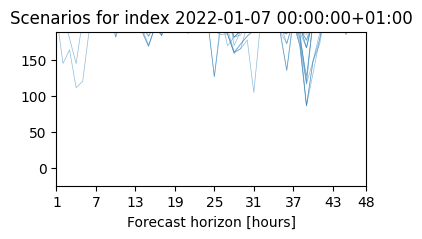

In [108]:
bn.plot_scenarios(250, 50)

array([<Axes: title={'center': 'Observations'}>,
       <Axes: title={'center': 'Generated scenarios'}>], dtype=object)

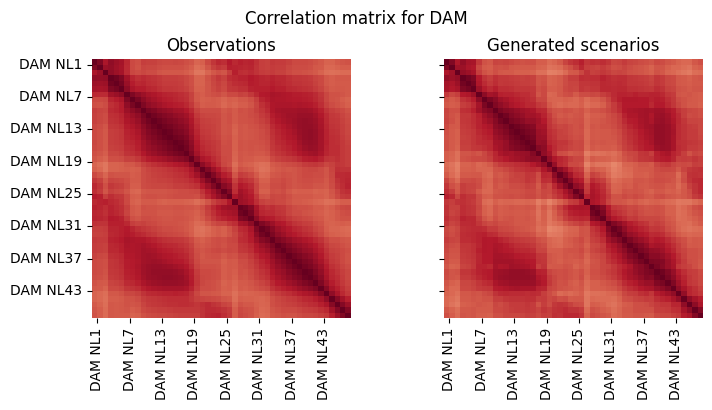

In [109]:
bn.plot_scenarios_R(100, 1000, fcname=name)

<Axes: >

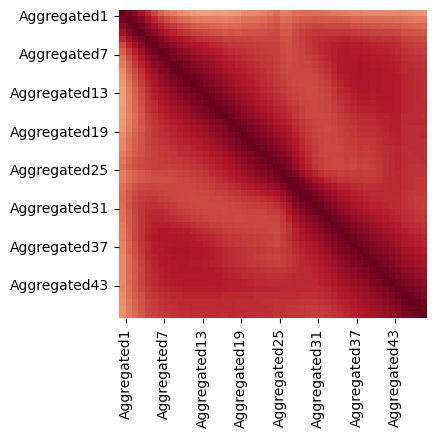

In [ ]:
bn.plot_R()

<Axes: >

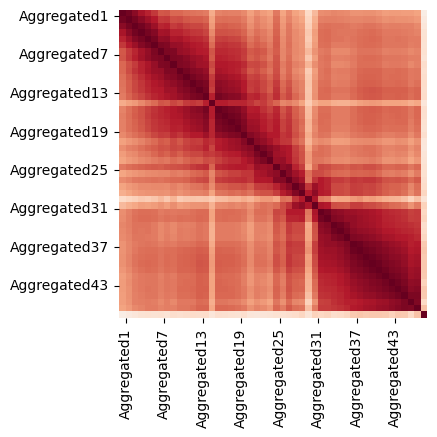

In [ ]:
bn.plot_scenario_correlation(0)

In [412]:
bn.R.shape

(48, 48)

['rayleigh', 'rayleigh', 'lognorm', 'norm', 'lognorm', 'invweibull', 'weibull_min', 'lognorm', 'weibull_min', 'weibull_min', 'lognorm', 'lognorm', 'lognorm', 'invweibull', 'lognorm', 'lognorm', 'lognorm', 'weibull_min', 'invweibull', 'weibull_min', 'lognorm', 'invweibull', 'lognorm', 'invweibull', 'lognorm', 'rayleigh', 'norm', 'weibull_min', 'lognorm', 'invweibull', 'weibull_min', 'weibull_min', 'weibull_min', 'weibull_min', 'rayleigh', 'weibull_min', 'rayleigh', 'norm', 'rayleigh', 'logistic', 'weibull_min', 'rayleigh', 'truncnorm', 'truncnorm', 'weibull_min', 'weibull_min', 'rayleigh', 'weibull_min'] 48


<Axes: >

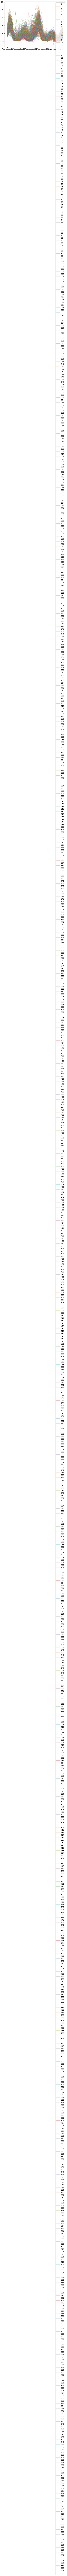

In [416]:
bn.sample_BN(distributionloader.index[0]).T.plot(lw=0.5, alpha=0.5)

In [388]:
bn(0)

('rayleigh', 'rayleigh', 'lognormal', 'normal', 'lognormal', 'invweibull', 'weibull_min', 'lognormal', 'weibull_min', 'weibull_min', 'lognormal', 'lognormal', 'lognormal', 'invweibull', 'lognormal', 'lognormal', 'lognormal', 'weibull_min', 'invweibull', 'weibull_min', 'lognormal', 'invweibull', 'lognormal', 'invweibull', 'lognormal', 'rayleigh', 'normal', 'weibull_min', 'lognormal', 'invweibull', 'weibull_min', 'weibull_min', 'weibull_min', 'weibull_min', 'rayleigh', 'weibull_min', 'rayleigh', 'normal', 'rayleigh', 'logistic', 'weibull_min', 'rayleigh', 'truncatednormal', 'truncatednormal', 'weibull_min', 'weibull_min', 'rayleigh', 'weibull_min')
([4.97632079, 5.07402825], [7.19926674, 7.78789012], [0.08268019, -50.76943378, 72.60946015], [20.62483101, 5.55263862], [0.20656891, -8.72284844, 21.77300641], [6089233.07486927, -16256818.38210097, 16256823.67671877], [1.22142209, 0.35908959, 3.41327504], [0.90711717, -0.23802614, 2.19945438], [0.90813977, 0.41489769, 2.67714095], [1.1240962

IndexError: index 0 is out of bounds for axis 0 with size 0

In [295]:
dists = DistributionLoader(df, 0, 'Aggregated', valmin, valmax)

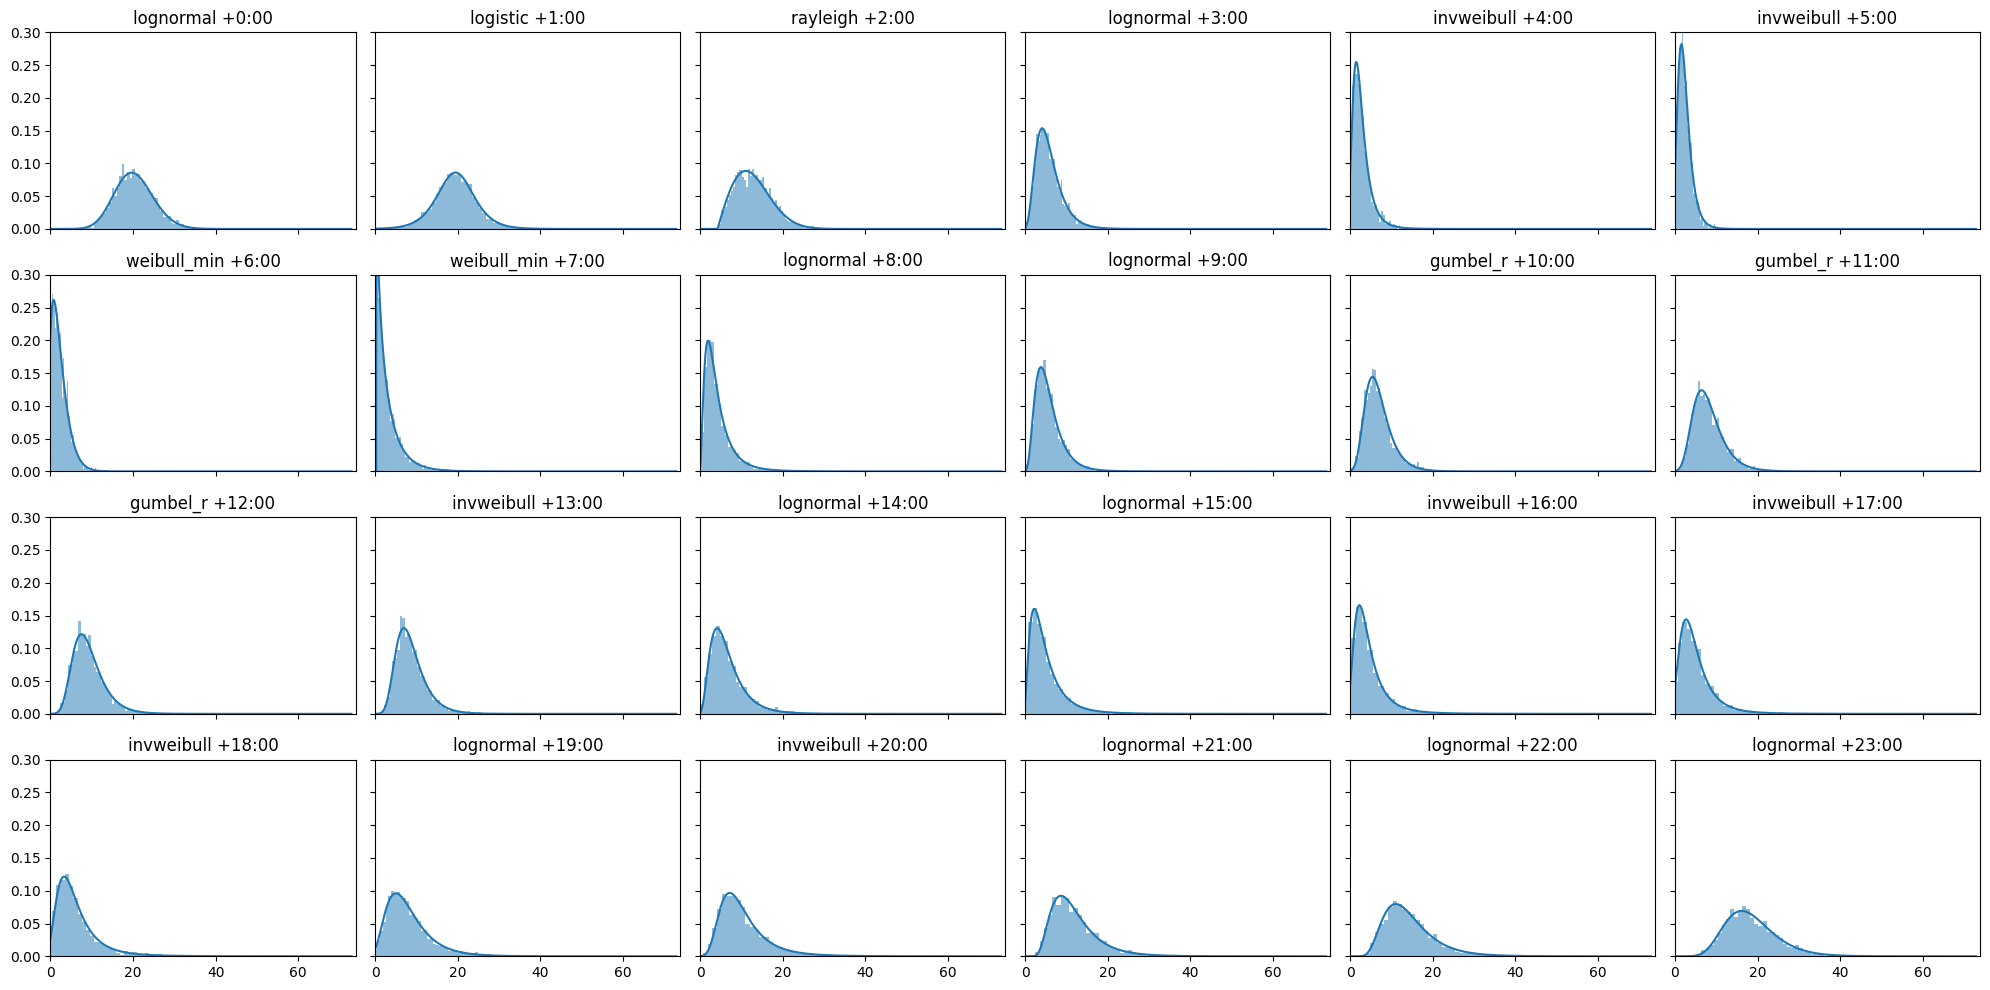

In [296]:
nplots=24
ncols=6
nrows = int(np.ceil(nplots/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(20, 10), sharex=True, sharey=True)
index = 2

for i in range(nplots):
    distname = dists.plot_pdf(df.index[2], i+1, ax=ax[i//ncols, i%ncols], title=f'+{i}:00', return_distname=True)
    ax[i//ncols, i%ncols].set_xlim(valmin, valmax+1)
    ax[i//ncols, i%ncols].set_ylim(0, 0.3)
    ax[i//ncols, i%ncols].set_title(f'{distname} +{i}:00')
fig.tight_layout()